In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


2025-04-18 20:27:29.192585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Close']]


In [ ]:
def preprocess_data(data, sequence_length):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    x, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        x.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y, scaler


In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
def train_and_predict(ticker='AAPL', start='2015-01-01', end='2024-01-01', sequence_length=60):
    data = get_stock_data(ticker, start, end)
    x, y, scaler = preprocess_data(data.values, sequence_length)
    model = build_model((x.shape[1], 1))
    model.fit(x, y, epochs=10, batch_size=32)

    # Predict on latest data
    latest_data = data[-sequence_length:].values
    latest_scaled = scaler.transform(latest_data)
    input_seq = np.reshape(latest_scaled, (1, sequence_length, 1))
    predicted_price = model.predict(input_seq)
    predicted_price = scaler.inverse_transform(predicted_price)
    print(f"Predicted next price for {ticker}: {predicted_price[0][0]:.2f}")

    return model


In [ ]:
if __name__ == '__main__':
    train_and_predict('AAPL', '2015-01-01', '2024-01-01')

# live

In [ ]:
def get_current_price(ticker):
    try:
        df = yf.download(ticker, period='1d', interval='1m', progress=False, threads=False)
        if df.empty or 'Close' not in df.columns:
            print(f"No data received for {ticker}.")
            return None
        latest_price = df['Close'].dropna().iloc[-1]  # Ensure we get a single float, not a Series
        return float(latest_price)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

# Example usage:
current_price = get_current_price('AAPL')
if current_price is not None:
    print(f"Live AAPL price: {current_price:.2f}")
else:
    print("Could not retrieve live price.")


In [ ]:
import time
from collections import deque

price_window = deque(maxlen=60)  # Store last 60 prices

while True:
    price = get_current_price('AAPL')
    if price:
        price_window.append(price)
        print(f"Collected: {price:.2f}")
    
    if len(price_window) == 60:
        # TODO: Predict next price here
        pass

    time.sleep(60)  # Wait for 1 minute


In [ ]:
# Assuming model and scaler are already loaded from training
scaled_input = scaler.transform(np.array(price_window).reshape(-1, 1))
x_live = np.reshape(scaled_input, (1, 60, 1))
predicted = model.predict(x_live)
predicted_price = scaler.inverse_transform(predicted)
print(f"📈 Predicted Next Price: {predicted_price[0][0]:.2f}")


# future

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 1. Get user input
ticker = input("Enter stock ticker: ").upper()
target_date = input("Enter future date (YYYY-MM-DD): ")
target_date = datetime.strptime(target_date, "%Y-%m-%d").date()

# 2. Download historical data
data = yf.download(ticker, start="2015-01-01", end=str(datetime.today().date()))
data = data[['Close']]

# 3. Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 4. Create dataset (sequence of 60 days)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 5. Train a simple model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32, verbose=0)

# 6. Predict days ahead
today = data.index[-1].date()
days_ahead = (target_date - today).days

if days_ahead <= 0:
    print("❌ Target date must be in the future.")
else:
    last_sequence = scaled_data[-60:]
    for _ in range(days_ahead):
        input_seq = last_sequence[-60:].reshape((1, 60, 1))
        next_price = model.predict(input_seq, verbose=0)
        last_sequence = np.append(last_sequence, next_price)[-60:]

    predicted_price = scaler.inverse_transform(next_price.reshape(-1, 1))[0][0]
    current_price = float(data['Close'].dropna().iloc[-1])

    print(f"\n📊 Current Price of {ticker}: {current_price:.2f}")
    print(f"🔮 Predicted Price on {target_date}: {predicted_price:.2f}")

    if predicted_price > current_price * 1.05:
        print("✅ Recommendation: Consider INVESTING 📈")
    elif predicted_price < current_price * 0.95:
        print("❌ Recommendation: Better to WAIT 💤")
    else:
        print("🤔 Recommendation: Too close to call, monitor trends.")


2025-04-18 20:27:45.277543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Enter stock ticker: RELIANCE.NS
Enter future date (YYYY-MM-DD): 2025-04-21
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



📊 Current Price of RELIANCE.NS: 1274.50
🔮 Predicted Price on 2025-04-21: 1234.47
🤔 Recommendation: Too close to call, monitor trends.


/var/folders/lg/x96k9k595fd23l822qs9gpvm0000gn/T/ipykernel_20950/1037817712.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].dropna().iloc[-1])


Enter stock ticker: RELIANCE.NS
Enter future date (YYYY-MM-DD): 2025-04-21


[*********************100%***********************]  1 of 1 completed



📊 Current Price of RELIANCE.NS: 1274.50
🔮 Predicted Price on 2025-04-21: 1333.18
🤔 Recommendation: Too close to call, monitor trends.

📉 RMSE on Training Data: 16.9961


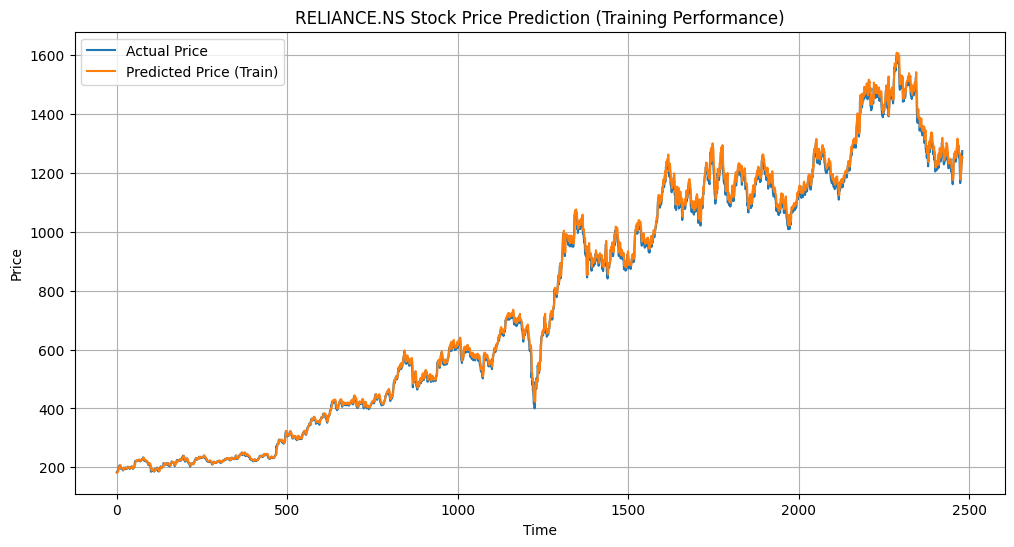

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Get user input
ticker = input("Enter stock ticker: ").upper()
target_date = input("Enter future date (YYYY-MM-DD): ")
target_date = datetime.strptime(target_date, "%Y-%m-%d").date()

# 2. Download historical data
data = yf.download(ticker, start="2015-01-01", end=str(datetime.today().date()))
data = data[['Close']]

# 3. Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 4. Create dataset (sequence of 60 days)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 5. Train a simple model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# 6. Predict days ahead
today = data.index[-1].date()
days_ahead = (target_date - today).days

if days_ahead <= 0:
    print("❌ Target date must be in the future.")
else:
    last_sequence = scaled_data[-60:]
    predicted_prices = []

    for _ in range(days_ahead):
        input_seq = last_sequence[-60:].reshape((1, 60, 1))
        next_price = model.predict(input_seq, verbose=0)
        predicted_prices.append(next_price[0][0])
        last_sequence = np.append(last_sequence, next_price)[-60:]

    predicted_price = scaler.inverse_transform(np.array(predicted_prices[-1]).reshape(-1, 1))[0][0]
    current_price = data['Close'].dropna().iloc[-1].item()


    print(f"\n📊 Current Price of {ticker}: {current_price:.2f}")
    print(f"🔮 Predicted Price on {target_date}: {predicted_price:.2f}")

    if predicted_price > current_price * 1.05:
        print("✅ Recommendation: Consider INVESTING 📈")
    elif predicted_price < current_price * 0.95:
        print("❌ Recommendation: Better to WAIT 💤")
    else:
        print("🤔 Recommendation: Too close to call, monitor trends.")

    # Evaluate model on training data
    predicted_train = model.predict(X, verbose=0)
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_train_prices = scaler.inverse_transform(predicted_train)

    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_train_prices))
    print(f"\n📉 RMSE on Training Data: {rmse:.4f}")

    # 9. Plot actual vs predicted on training data
    plt.figure(figsize=(12,6))
    plt.plot(actual_prices, label='Actual Price')
    plt.plot(predicted_train_prices, label='Predicted Price (Train)')
    plt.title(f'{ticker} Stock Price Prediction (Training Performance)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
